# Porfolio optimalization using Monte Carlo Simulation
This project implements Modern Portfolio Theory (MPT) to determine the optimal asset allocation. 

The goal is to maximalize **Sharpe Ratio**, defined as

$$S_p = \frac{E[R_p]- R_f}{\sigma_p}$$

where:
* $E[R_p]$ is the expected return of porfolio
* $R_f$ is the risk-free interest rate (we assume $R_f = 0$)
* $\sigma_p$ is the portfolio volatility 

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
ticker_list = ['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'JPM','V','JNJ','KO', 'CVX']

In [ ]:
data = yf.download(ticker_list,start="2024-01-01", auto_adjust=True)['Close']

### mathematical model
The expected annual portfolio return is computed as the scalar product of the weight vector and the vector of expected returns

$$E[R_p] = \mathbf{w}^T E[\mathbf{R}]$$

The porfolio risk (variance) is given by the quadratic form involving the covarience matrix $\Sigma$

$${\sigma_p}^2 = \mathbf{w}^T \Sigma\mathbf{w}$$

For the simulation, we generat $N = 10 000$ random weight vectors $\mathbf{w}$ subject to the constrains

$$\sum_{i=1}^{n} w_i = 1, \quad w_i \ge 0$$





In [ ]:
daily_returns = np.log(data / data.shift(1)).dropna()

In [ ]:
annual_returns = daily_returns.mean() * 258
cov_matrix = daily_returns.cov() * 258

In [ ]:
num_portfolios = 10000
results = np.zeros((3,num_portfolios))
all_weights = np.zeros((num_portfolios,10))

for i in range(num_portfolios):
    weights = np.random.random(10)
    weights /= np.sum(weights)
    all_weights[i,:] = weights

    portfolio_return = np.dot(weights.T, annual_returns)

    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights)))

    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]

Benchmark with S&P 500

In [ ]:
spy_data = yf.download('SPY',start='2024-01-01', auto_adjust=True)['Close']

In [ ]:
spy_daily_returns = np.log(spy_data / spy_data.shift(1)).dropna()

In [ ]:
spy_annual_return = spy_daily_returns.mean() * 258
spy_annual_volatility = spy_daily_returns.std() * np.sqrt(252)

In [32]:
sort_idx = np.argsort(results[1,:])
sorted_vol = results[1, sort_idx]
sorted_ret = results[0, sort_idx]

In [33]:
frontier_vol = []
frontier_ret = []
current_max_return = -np.inf

for i in range(len(sorted_vol)):
    if sorted_ret[i] > current_max_return:
        frontier_vol.append(sorted_vol[i])
        frontier_ret.append(sorted_ret[i])
        current_max_return = sorted_ret[i]

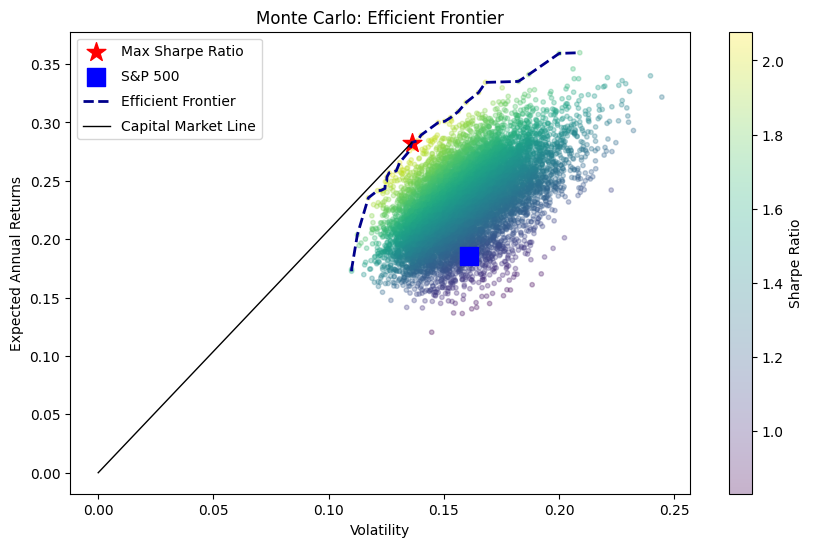

In [35]:
plt.figure(figsize=(10,6))
plt.scatter(results[1,:],results[0,:],c=results[2,:],cmap='viridis', marker='o',s=10,alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

max_sharpe_idx = np.argmax(results[2,:])
sdp, rp = results[1,max_sharpe_idx], results[0,max_sharpe_idx]

plt.scatter(sdp, rp, color='r', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(spy_annual_volatility, spy_annual_return, color='b', marker='s', s=150, label='S&P 500')

plt.plot(frontier_vol, frontier_ret, color='darkblue', linestyle='--', linewidth=2, label='Efficient Frontier')

plt.plot([0,sdp], [0,rp], color='black', linestyle='-', linewidth=1, label='Capital Market Line')

plt.title('Monte Carlo: Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Annual Returns')
plt.legend(labelspacing=0.8)
plt.show;


In [ ]:
print('Optimal weights for the best Sharpe Ratio:')
for i, ticker in enumerate(ticker_list):
    print(f"{ticker}: {all_weights[max_sharpe_idx, i]: .2%}")

### Value at Risk (VaR)
To measure market risk, we use the parametric VaR at the $95%$ confidence level.
It represents the maximum expeced loss over a one-day horiont under the assumption of normally distributed returns

$$\text{VaR}_{95\%} = \mu_p - 1,645 \sigma_p^{daily}$$

where:
* $\mu_p$ is the expected daily porfolio return,
* $\sigma_p^{daily}$ is the daily portfolio volatility,
* $1,645$ is the $95%$ quantile of the standard normal distribution

In [ ]:
best_portfolio_daily_return = rp / 252
best_portfolio_daily_vol = sdp / np.sqrt(252)

var_95 = best_portfolio_daily_return - (1.645 * best_portfolio_daily_vol)

print(f"95% Daily VaR: {var_95:.2%}")

print(f"That means that, with 95% confidence, the one-day portfolio loss will not exceed {abs(var_95):.2%}.")
print(f"Equivalently, there is a 5% probability that the portfolio will lose more than {abs(var_95):.2%} in a single day.")